#### Run this cell first to import libraries and set variables

In [1]:
import os, sys
import matplotlib
matplotlib.use('Agg')
%matplotlib inline  
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

#set start time, end time and time step 
start_time = 0
end_time = 30
time_step = 5

#### Draw topography map
change "time" variable to see topography at certain time

In [ ]:
time = 0 #change this number to draw topography map at certain time

#the location and naming convention of topography files
topo_dir = '../data/topo_grids/'

#read in data
data = np.genfromtxt(topo_dir + '/{0}Ma_smooth.xyz'.format(time))
x = data[:,0]
y = data[:,1]
z = data[:,2]

#initialize figure and basemap
plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)
xi, yi = m(x, y)
v_min = -5000
v_max = 5000

#reorder the data so that it can be used in imshow
zz = z.reshape((181, 361))
zz = np.flipud(zz)

#intopolate data and draw map
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data, alpha=0.5, vmin=v_min, vmax=v_max, cmap='terrain')

#draw meridians and parallels
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

#draw colour bar and title
cbar = m.colorbar(cs, location='bottom', pad="10%", label='Topography (m)')
plt.title("{1} at {0} Ma".format(time, 'Topography'))

plt.show()


#### NASA Present Day Temperature Map

In [ ]:
#read in data
data = np.genfromtxt('../data/SurfaceTemperature_NASA.xyz')
topo_data = np.genfromtxt('../data/topo_grids/0Ma_smooth.xyz')

x = data[:,0]
y = data[:,1]
z = data[:,2]
xt = topo_data[:,0]
yt = topo_data[:,1]
topo = topo_data[:,2]
topo = np.where(topo>0, 1, 0)

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

x, z = m.shiftdata(x, datain = z, lon_0=0)

xi, yi = m(x, y)
xit, yit = m(xt, yt)
v_min = -60
v_max = 40     

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xit.reshape((181,361)), yit.reshape((181,361)), topo.reshape((181,361)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Degree Celsius')

plt.title("NASA Present Day Temperature")

plt.show()

#### NASA Present Day Precipitation 

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


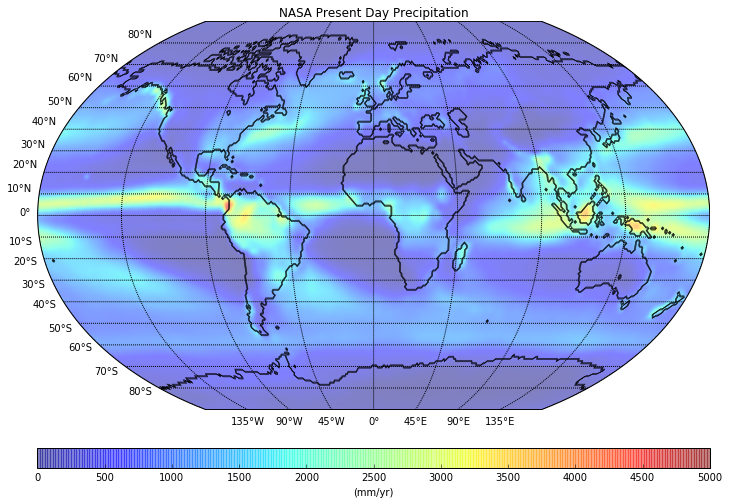

In [2]:
data = np.genfromtxt('../data/SurfacePrecipitation_NASA.xyz')
topo_data = np.genfromtxt('../data/topo_grids/0Ma_smooth.xyz')

x = data[:,0]
y = data[:,1]
z = data[:,2] * 356
xt = topo_data[:,0]
yt = topo_data[:,1]
topo = topo_data[:,2]
topo = np.where(topo>0,1, 0)

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

x, z = m.shiftdata(x, datain = z, lon_0=0)

xi, yi = m(x, y)
xit, yit = m(xt, yt)

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, clim=[0,5000], cmap='jet')

m.contour( xit.reshape((181,361)), yit.reshape((181,361)), topo.reshape((181,361)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='(mm/yr)')

plt.title("NASA Present Day Precipitation")

plt.show()

#### Run the model. It will take a while to finish, be patient ...

In [ ]:
import sys
sys.path.append('../reconstruction')
sys.path.append('../utils')

from reconstruct_atom_data import *
from pyatom import Atmosphere, Hydrosphere

#create the models
atm_model = Atmosphere()
hyd_model = Hydrosphere()

#load configurations
atm_model.load_config( './config_atm.xml' )
hyd_model.load_config( './config_hyd.xml' )

#set the iteration number
atm_model.velocity_iter_max = 2
atm_model.pressure_iter_max = 2

hyd_model.velocity_iter_max = 2
hyd_model.pressure_iter_max = 2

times = range(start_time, end_time+1, time_step)

#run the models
for idx, time in enumerate(times):
    atm_model.run_time_slice(time)
    hyd_model.run_time_slice(time)#hyd model depends on atm model. must run atm model before hyd model
    if idx < len(times)-1:
        reconstruct_temperature(time,times[idx+1]) 
        reconstruct_precipitation(time,times[idx+1])
        reconstruct_salinity(time,times[idx+1])



#### Temperature Map

In [ ]:
time = 0 #change this number to draw precipitation at certain time

air_or_ocean = 'Atm' #'Atm for air'
#air_or_ocean = 'Hyd' #'Hyd for ocean'

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_{1}.xyz'.format(time, air_or_ocean), skip_header=1)
        
x = data[:,0]
y = data[:,1]
z = data[:,6]
topo = data[:,2]

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)

xi, yi = m(x, y)
v_min = -60
v_max = 40     

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Celsius')

if air_or_ocean == "Atm":
    title_prefix = 'Air'
else:
    title_prefix = 'Water'
plt.title("{2} {1} at {0}Ma".format(time, 'Temperature', title_prefix))

plt.show()

#### Precipitation Map

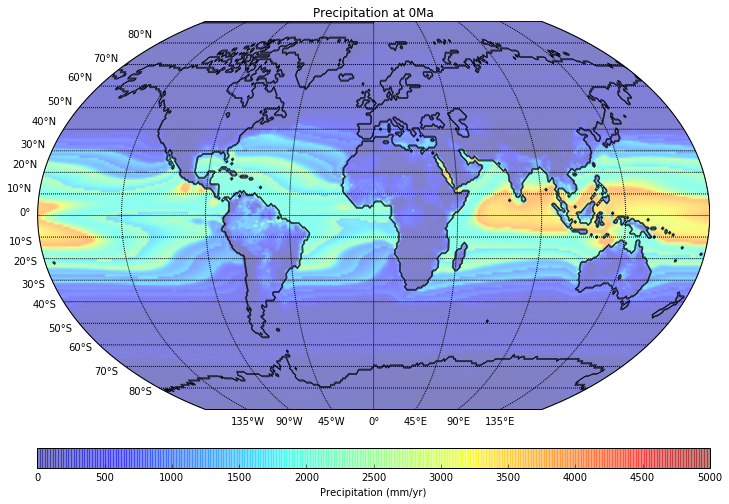

In [3]:
time = 0 #change this number to draw precipitation at certain time

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_Atm.xyz'.format(time), skip_header=1)
        
x = data[:,0]
y = data[:,1]
z = data[:,8]
topo = data[:,2]

z=z*365 #365 days in one year

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)

xi, yi = m(x, y)
v_min = 0
v_max = 5000     

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Precipitation (mm/yr)')
plt.title("{1} at {0}Ma".format(time, 'Precipitation'))

plt.show()

#### Atmospheric Velocity Map

In [ ]:
time = 0

def down_sample(a):
    tmp=[]   
    for t in a:
        tmp.append(t[3::4])
    return tmp[3::4]

air_or_ocean = 'Atm' #'Atm for air'
#air_or_ocean = 'Hyd' #'Hyd for ocean'

zeros = np.zeros(181*361)

vm_0 = np.fromfile('./output/bin_data/m_{}_n_0.bin'.format(time),'<f8')
v_0 = np.fromfile('./output/bin_data/v_{}_n_0.bin'.format(time),'<f8')
w_0 = np.fromfile('./output/bin_data/w_{}_n_0.bin'.format(time),'<f8')
h = np.fromfile('./output/bin_data/h_{}_n_0.bin'.format(time),'<f8')

mask = np.isclose(vm_0,zeros)

for layer_idx in range(1,41):

    vm = np.fromfile('./output/bin_data/m_{0}_n_{1}.bin'.format(time, layer_idx),'<f8')
    v = np.fromfile('./output/bin_data/v_{0}_n_{1}.bin'.format(time, layer_idx),'<f8')
    w = np.fromfile('./output/bin_data/w_{0}_n_{1}.bin'.format(time,layer_idx),'<f8')
    

    vm = vm*mask
    vm_0 = vm_0 + vm
    v = v*mask
    v_0 = v_0 + v
    w = w*mask
    w_0 = w_0 + w
    mask = np.isclose(vm_0,zeros)
    
vm = vm_0
v = v_0
w = w_0

x = np.linspace(-180, 180, 361)
y = np.linspace(-90, 90, 181)
xv, yv = np.meshgrid(x, y)
#print xv
#print yv

figure = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl', lon_0=0)

xi, yi = m(xv.flatten(), yv.flatten())

xi = xi.reshape((181,361)) 
yi = yi.reshape((181,361)) 
vm = vm.reshape((181,361)) 
w = w.reshape((181,361)) 
v = v.reshape((181,361)) 
h = h.reshape((181,361)) 
    
wn = down_sample(w) 
vn = down_sample(-v)
wn = wn / np.sqrt(np.square(wn) + np.square(vn))
vn = vn / np.sqrt(np.square(wn) + np.square(vn))
cs = m.quiver(down_sample(xi), down_sample(yi), wn, vn, down_sample(vm), width=0.001,
         headlength=7, headwidth=5, pivot='tail', clim=[0, 1.2], cmap='jet')


m.contour( xi, yi, h, colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)
#m.drawcoastlines()   

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Velocity (m/s)')
plt.title("Atmospheric Velocity at {}Ma".format(time))

plt.show()

#### Ocean Current Velocity Map

In [ ]:
time = 5

def down_sample(a):
    aa = a.reshape((361,181))
    tmp=[]
    for t in aa:
        tmp.append(t[3::4])
    return tmp[3::4]

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_Hyd.xyz'.format(time), skip_header=1)
x = data[:,0]
y = data[:,1]
z = data[:,6]

vx=-data[:,3]
vy=data[:,4]
magitude = data[:,5]
topo = data[:,2]

figure = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='cyl', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)
x, vx = m.shiftdata(xx, datain = vx, lon_0=0)
x, vy = m.shiftdata(xx, datain = vy, lon_0=0)
x, magitude = m.shiftdata(xx, datain = magitude, lon_0=0)

xi, yi = m(x, y)
    
cs = m.quiver(down_sample(xi), down_sample(yi), down_sample(vy), down_sample(vx), down_sample(magitude), width=0.001,
         headlength=7, headwidth=5, pivot='tail', clim=[0, 0.04], cmap='jet')
   
m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                        colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)
#m.drawcoastlines()   

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Velocity (m/s)')
plt.title("Ocean Current Velocity at {}Ma".format(time))
plt.show()


#### Salinity Map

In [ ]:
time = 0 #change this number to draw Salinity at certain time

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_Hyd.xyz'.format(time), skip_header=1)
        
x = data[:,0]
y = data[:,1]
z = data[:,7]
topo = data[:,2]

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)

xi, yi = m(x, y)
v_min = 34
v_max = 39     

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Salinity (psu)')
plt.title("{1} at {0}Ma".format(time, 'Salinity'))

plt.show()

#### Upwelling Map

In [ ]:
time = 0 #change this number to draw Salinity at certain time

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_Hyd.xyz'.format(time), skip_header=1)
        
x = data[:,0]
y = data[:,1]
z = data[:,9]
#print z.min(), z.max()
topo = data[:,2]

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)

xi, yi = m(x, y)
v_min = 0
v_max = 0.06   

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Upwelling (m/s)')
plt.title("{1} at {0}Ma".format(time, 'Upwelling'))

plt.show()

#### Downwelling Map

In [ ]:
time = 0 #change this number to draw Salinity at certain time

data = np.genfromtxt('./output/[{0}Ma_smooth.xyz]_PlotData_Hyd.xyz'.format(time), skip_header=1)
x = data[:,0]
y = data[:,1]
z = data[:,10]
#print z.min(), z.max()
topo = data[:,2]

fig = plt.figure(figsize=(15, 8))
m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

xx = x
x, topo = m.shiftdata(xx, datain = topo, lon_0=0)
x, z = m.shiftdata(xx, datain = z, lon_0=0)
xi, yi = m(x, y)

v_min = 0
v_max = 0.1    

zz = np.zeros((181, 361))
for i in range(181):
    for j in range(361):
        zz[180-i][j] = z[j*181+i]
img_data = m.transform_scalar(zz, np.arange(-180,180),np.arange(-90,90),361,181)
cs = m.imshow(img_data,alpha=0.5, vmin=v_min, vmax=v_max, cmap='jet')

m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                    colors ='k', linewidths= 0.3 )
m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

cbar = m.colorbar(cs, location='bottom', pad="10%", label='Downwelling (m/s)')
plt.title("{1} at {0}Ma".format(time, 'Downwelling'))

plt.show()

#### this cell will draw a line plot to show the temperature change over time at a given location 

In [ ]:
lon = 10
lat = 35

#reconstruct the location
import pygplates
rotation_dir = '../reconstruction/data'
rotation_model = pygplates.RotationModel(
        rotation_dir + '/Rotations/Global_EarthByte_230-0Ma_GK07_AREPS.rot' )
static_polygon_features = pygplates.FeatureCollection(
        rotation_dir + '/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz' )

point_feature = pygplates.Feature()
point_feature.set_geometry(pygplates.PointOnSphere(float(lat),float(lon)))
    
assigned_point_feature = pygplates.partition_into_plates(
        static_polygon_features,
        rotation_model,
        point_feature,
        properties_to_copy = [
            pygplates.PartitionProperty.reconstruction_plate_id,
            pygplates.PartitionProperty.valid_time_period],
        )

data = []
reconstructed_feature_geometries = []

import numpy as np

for time in range(start_time, end_time+1, time_step):
    d = np.fromfile('./output/bin_data/t_{0}_4_0.bin'.format(time),'<f8')
    d = d.reshape((181, 361))
    pygplates.reconstruct(
            assigned_point_feature,
            rotation_model,
            reconstructed_feature_geometries,
            float(time),
            anchor_plate_id=0)
    if reconstructed_feature_geometries:
        geom =  reconstructed_feature_geometries[0].get_reconstructed_geometry()
        p = geom.to_lat_lon_list()[0]
        data.append(d[int(p[0])+90, int(p[1])+180])  
    
plt.plot(range(start_time, end_time+1, time_step), data)
plt.ylabel("Temperature (Celsius)")
plt.xlabel("Time (millon years)")
plt.show()